# GCN explainability demo (real data)

This notebook runs a short training on the repository dataset and then runs the explainers on a randomly selected monomer. Run top-to-bottom to reproduce the training+explain flow. The long in-notebook training block was replaced with a short runner that calls `main.py` and then loads the produced checkpoint so the explainability cells can run in the same kernel.

In [6]:
import os
import sys
# Ensure repo root is on sys.path so `src` imports work when launched from notebooks/ or repo root
sys.path.insert(0, os.path.abspath('..'))

import torch
import matplotlib.pyplot as plt
import networkx as nx

# Repo helpers and model
from src.models.gcn import SimpleGCN
from src.models.explainability.GNNExplainer import explain_with_gnnexplainer
from src.models.explainability.zorro import zorro_node_importance

%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)

print('Python', sys.version)
print('Torch', torch.__version__)


Python 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Torch 2.9.0+cpu


In [7]:
# Train inside the notebook and run explainers on a random monomer
import os, sys, random
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.model_selection import train_test_split

# Determine repository root robustly by walking up until we find a project marker
def find_repo_root(start_path=None):
    start = start_path or os.getcwd()
    cur = os.path.abspath(start)
    markers = ("pyproject.toml", "setup.py", "src", ".git")
    while True:
        for m in markers:
            if os.path.exists(os.path.join(cur, m)):
                return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            # fallback to original cwd if nothing found
            return os.path.abspath(start)
        cur = parent

repo_root = find_repo_root()
print('Repository root detected as:', repo_root)

# Ensure repo root on sys.path so `src` imports work when launched from notebooks/ or repo root
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

# Notebook-local copies of helper wrappers/classes (compatible with main.py)
from src.preprocessing.oligomer import OligomerPreprocessor
from src.loss.masked_loss import WeightedMAELoss
from src.models.gcn import SimpleGCN

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

# Lightning wrapper (same contract as main.py)
class LightningModel(pl.LightningModule):
    def __init__(self, model, optimizer, scheduler, loss_fn, batch_size, hparams=None):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.batch_size = batch_size
        if hparams:
            self.save_hyperparameters(hparams)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss

    def configure_optimizers(self):
        if self.scheduler is not None:
            return [self.optimizer], [self.scheduler]
        else:
            return [self.optimizer]

# Small helper dataset wrapper
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

print('Reading data...')
# Use absolute path to the data file so running from notebooks/ works
data_csv = os.path.join(repo_root, 'data', 'raw', 'train.csv')
print('Reading data file:', data_csv)
df = pd.read_csv(data_csv)
X = df['SMILES'].values
Y = df[['Tg','FFV','Tc','Density','Rg']].values

# Train/Val/Test split (same ratios as main.py)
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.17, random_state=42)

print('Preprocessing (this may take a moment)...')
pre = OligomerPreprocessor(oligomer_len=1)
X_train_graphs = pre.fit_transform(X_train)
X_val_graphs = pre.transform(X_val)
X_test_graphs = pre.transform(X_test)

# compute loss stats robustly (handle NaNs)
import numpy as np
property_ranges = torch.tensor([ np.nanmax(Y[:,i]) - np.nanmin(Y[:,i]) for i in range(Y.shape[1]) ], dtype=torch.float32)
num_samples_per_property = torch.tensor([ np.sum(~np.isnan(Y[:,i])) for i in range(Y.shape[1]) ], dtype=torch.float32)
loss_fn = WeightedMAELoss(property_ranges, num_samples_per_property)

# dataloaders
batch_size = 32
train_dl = DataLoader(GraphDataset(X_train_graphs, Y_train), batch_size=batch_size, shuffle=True)
val_dl = DataLoader(GraphDataset(X_val_graphs, Y_val), batch_size=batch_size)
test_dl = DataLoader(GraphDataset(X_test_graphs, Y_test), batch_size=batch_size)

# instantiate model (use detected in_channels from graphs)
in_ch = X_train_graphs[0].x.size(1) if len(X_train_graphs)>0 else 9
model = SimpleGCN(in_channels=in_ch, hidden_channels=[64,128,128,128,128,64], out_channels=5, activation=torch.nn.ReLU(), improved=True, use_layer_norm=True, dropout=0.1)

# optimizer/scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = None

# Lightning wrapper
lightning_model = LightningModel(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, batch_size=batch_size, hparams={})

# checkpoint callback saved inside notebook
ckpt_dir = os.path.join(repo_root, 'checkpoints')
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_cb = ModelCheckpoint(dirpath=ckpt_dir, filename='best', monitor='val_loss', save_top_k=1, mode='min')

# offline wandb logger to avoid cloud
logger_dir = os.path.join(repo_root, 'lightning_logs')
logger = WandbLogger(project='polymer-prediction', offline=True, save_dir=logger_dir)

trainer = pl.Trainer(max_epochs=1, accelerator='cpu', logger=logger, callbacks=[ckpt_cb])
print('Starting training...')
trainer.fit(lightning_model, train_dl, val_dl)
print('Training finished.')
trainer.test(lightning_model, test_dl)

# Use trained model in memory for explainers
trained_model = lightning_model.model
trained_model.eval()

Repository root detected as: c:\Users\20210926\Desktop\Personal\university\TU Deflt\Sem 1\Data science GML\Project\dsait-4305-polymer-prediction
Reading data...
Reading data file: c:\Users\20210926\Desktop\Personal\university\TU Deflt\Sem 1\Data science GML\Project\dsait-4305-polymer-prediction\data\raw\train.csv
Preprocessing (this may take a moment)...


Processing SMILES string to oligomer of length 1: 100%|██████████| 1196/1196 [00:01<00:00, 948.13it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\20210926\Desktop\Personal\university\TU Deflt\Sem 1\Data science GML\Project\dsait-4305-polymer-prediction\checkpoints exists and is not empty.

  | Name    | Type            | Params | Mod

Starting training...
                                                                           

C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 176/176 [00:08<00:00, 21.83it/s, v_num=uv82, train_loss_step=0.230, val_loss=0.243, train_loss_epoch=0.245]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 176/176 [00:08<00:00, 21.77it/s, v_num=uv82, train_loss_step=0.230, val_loss=0.243, train_loss_epoch=0.245]

C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Training finished.
Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 54.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22300860285758972
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 54.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22300860285758972
───────────────────────────────────────────────────

SimpleGCN(
  (act): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (convs): ModuleList(
    (0): GCNConv(9, 64)
    (1): GCNConv(64, 128)
    (2-4): 3 x GCNConv(128, 128)
    (5): GCNConv(128, 64)
  )
  (norms): ModuleList(
    (0): LayerNorm(64, affine=True, mode=graph)
    (1-4): 4 x LayerNorm(128, affine=True, mode=graph)
    (5): LayerNorm(64, affine=True, mode=graph)
  )
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

## Explaining code
The following code runs the explainability component. runs explanation and plots the explanation.


Selected SMILES for explanation: *C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OCCCCCCCCCC)c3)c2c1


Processing SMILES string to oligomer of length 1: 100%|██████████| 1/1 [00:00<?, ?it/s]

Running Zorro...


Zorro: tensor([0.2496, 1.0000, 0.7844, 0.6033, 0.2648, 0.1150, 0.0408, 0.1257, 0.2821,
        0.4748, 0.6836, 0.0613, 0.3055, 0.0947, 0.0629, 0.1362, 0.1075, 0.0686,
        0.0018, 0.1356, 0.0743, 0.1733, 0.2252, 0.2666, 0.2793, 0.2926, 0.3407,
        0.4780, 0.6639, 0.5125, 0.0414, 0.1189, 0.0703, 0.1753, 0.2274, 0.2681,
        0.2799, 0.2927, 0.3408, 0.4780, 0.6639, 0.5125, 0.1428, 0.0177, 0.1424])
Running GNNExplainer...
GNN mask: tensor([0.0034, 0.0041, 0.0045, 0.0052, 0.0046, 0.0042, 0.0046, 0.0046, 0.0043,
        0.0043, 0.0048, 0.0030, 0.0042, 0.0047, 0.0045, 0.0047, 0.0042, 0.0044,
        0.0053, 0.0045, 0.0043, 0.0038, 0.0035, 0.0033, 0.0032, 0.0032, 0.0033,
        0.0032, 0.0032, 0.0025, 0.0053, 0.0045, 0.0043, 0.0038, 0.0035, 0.0033,
        0.0032, 0.0032, 0.0033, 0.0032, 0.0032, 0.0025, 0.0042, 0.0046, 0.0044])


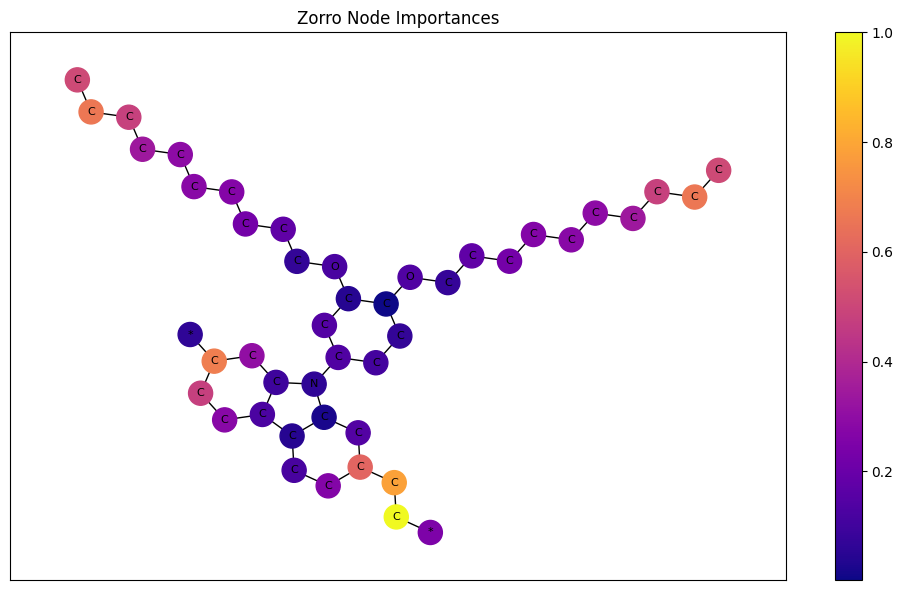

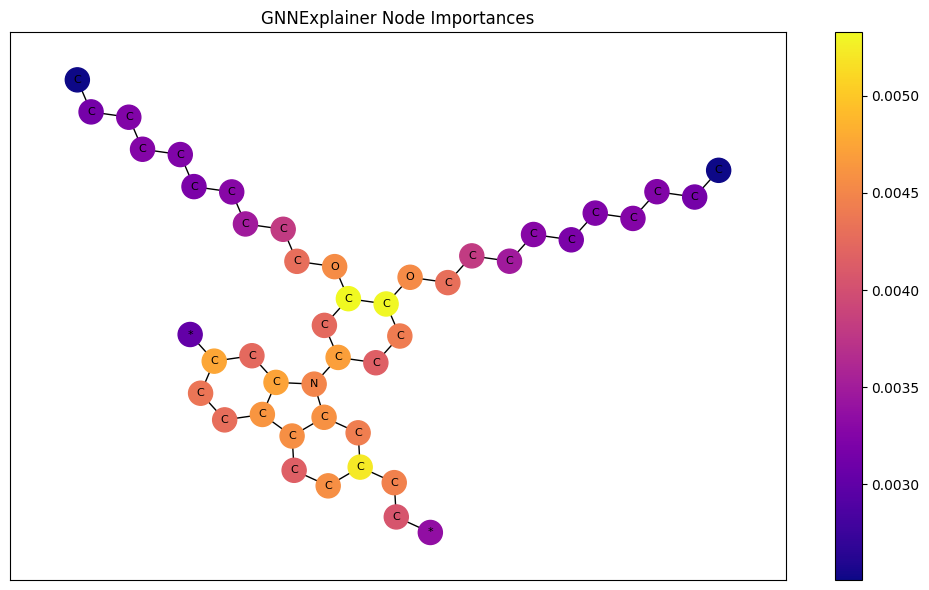

In [ ]:
# Pick a random SMILES for explanation
smiles = df['SMILES'].dropna().sample(1, random_state=42).iloc[0]
print('Selected SMILES for explanation:', smiles)

graphs = pre.transform([smiles])
if len(graphs)==0:
    raise RuntimeError('Preprocessing returned no graph for chosen SMILES')
data = graphs[0]
# ensure batch
n_nodes = int(data.x.size(0))
data.batch = torch.zeros(n_nodes, dtype=torch.long)

# run explainers
from src.models.explainability.zorro import zorro_node_importance
from src.models.explainability.GNNExplainer import explain_with_gnnexplainer, visualize_node_importance


print('Running Zorro...')
z_imp = zorro_node_importance(trained_model, data)
print('Zorro:', z_imp)
print('Running GNNExplainer...')
res = explain_with_gnnexplainer(trained_model, data)
g_imp = res.get('node_mask') if isinstance(res, dict) else None
print('GNN mask:', g_imp)

visualize_node_importance(data, z_imp, title='Zorro Node Importances')
visualize_node_importance(data, g_imp, title='GNNExplainer Node Importances')

